In [2]:
import pandahouse
import swifter
import hashlib
import seaborn as sns
import scipy.stats as stats

In [3]:
#функция для разбиения на группы -- сплитования
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [4]:
#подключение к серверу
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [5]:
#вытащили уникальных пользователей за промежуток
q = """
SELECT distinct user_id
FROM {db}.feed_actions 
WHERE toDate(time) >= '2021-11-15' and toDate(time) <= '2021-11-21' 
"""

users_df = pandahouse.read_clickhouse(q, connection=connection)
users_df.head()

,user_id
0,2576
1,126738
2,130333
3,130484
4,137919


In [6]:
# Сделали группы
users_df['hash_group'] = users_df.user_id.swifter.apply(ab_split)

# Смотрим на число пользователей в каждой группе
users_df.groupby('hash_group').user_id.nunique().reset_index()

Pandas Apply:   0%|          | 0/50149 [00:00<?, ?it/s]

,hash_group,user_id
0,0,10151
1,1,9982
2,2,9977
3,3,9963
4,4,10076


Второй вариант -- хэширование в КликХаусе 
q = """
SELECT xxHash64(toString(user_id)||'my_salt')%5 as group, 
    uniqExact(user_id)
FROM {db}.feed_actions 
WHERE toDate(time) >= '2021-11-15' and toDate(time) <= '2021-11-21' 
group by group 
"""

pandahouse.read_clickhouse(q, connection=connection)

In [7]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2021-11-08' and '2021-11-14'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


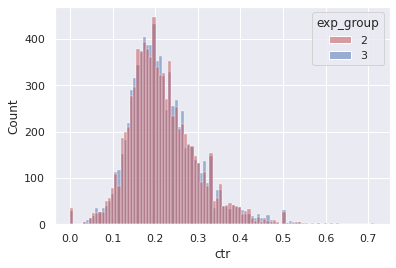

In [8]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [9]:
#проводим Т-тест Стьюдента для проверки что группы правда равны друг другу
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

In [10]:
#Проводим непараметрический тест Манна-Уитни для сравнения групп
print(stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr))

print('Отличие не прокрасилось') 

MannwhitneyuResult(statistic=36124728.5, pvalue=0.5177480614337441)
Отличие не прокрасилось


In [11]:
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 3].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')
#Грузится примерно 10-15 секунд!

В 50.26 % случаев A > B. Должно получиться около 50%


A/B тест 

* exp_group = 1 - Все по-старому
* exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

* exp_group = 0 – Все по-старому
* exp_group = 3 - Рекомендации "постов, которые лайкали похожие на вас люди"

In [12]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2021-11-15' and '2021-11-21'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#T-тест

stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

In [13]:
#Манн-Уитни
stats.mannwhitneyu(df[df.exp_group == 0].ctr, 
                   df[df.exp_group == 3].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43682792.0, pvalue=1.1952055473582936e-57)

/tmp/ipykernel_49/3363906862.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1.ctr,


<Axes: xlabel='ctr'>

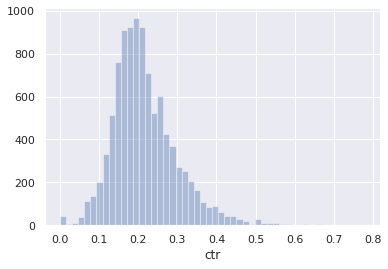

In [14]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2021-11-15' and '2021-11-21'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

global_ctr_1 = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()
global_ctr_2 = df[df.exp_group == 3].likes.sum()/df[df.exp_group == 3].views.sum()

group1 = df[df.exp_group == 0].copy()
sns.distplot(group1.ctr, 
             kde = False)



In [ ]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr, 
             kde = False)